In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [7]:
# Parameters
batch_size = 64
img_height = 224
img_width = 224

data_dir = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'


In [8]:
# Load the dataset
train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    validation_split=0.1,
    subset='training',
    seed=123,
    batch_size=batch_size
)
val = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset='validation',
    seed=123,
    batch_size=batch_size
)

Found 12446 files belonging to 4 classes.
Using 11202 files for training.
Found 12446 files belonging to 4 classes.
Using 2489 files for validation.


In [9]:
# Class labels
label_to_class_name = dict(zip(range(len(train.class_names)), train.class_names))


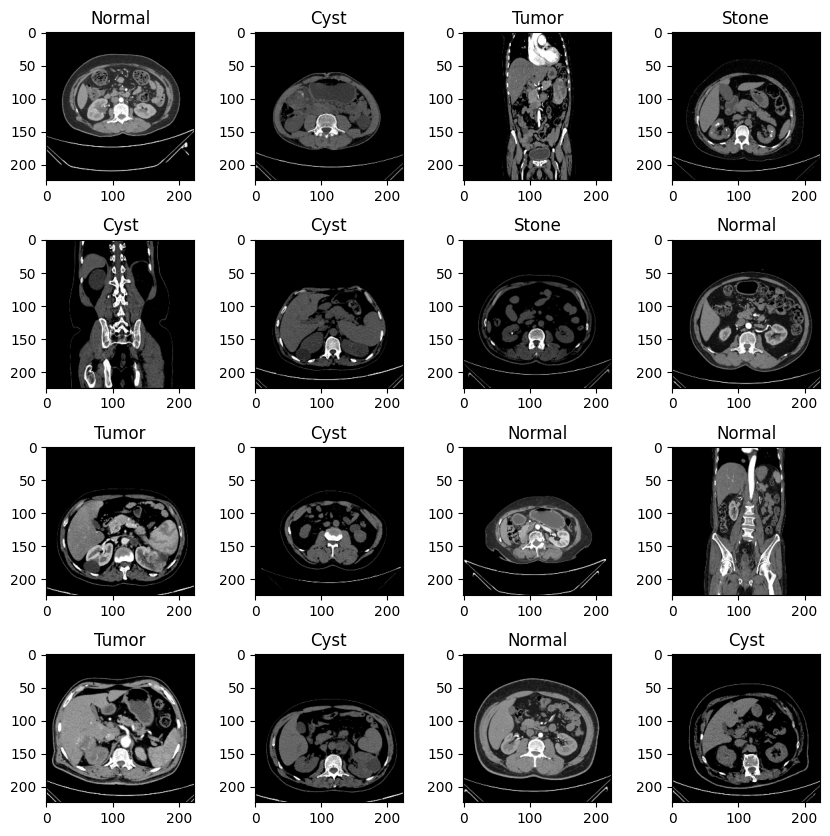

In [10]:
# Visualize some training images
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):  
    for j in range(4):  
        index = i * 4 + j  
        ax[i, j].imshow(batch[0][index].astype(int))
        ax[i, j].set_title(label_to_class_name[batch[1][index]])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [11]:
# Normalize images
train = train.map(lambda x, y: (x / 255.0, y))
val = val.map(lambda x, y: (x / 255.0, y))


In [12]:
# Prefetching for performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)


In [13]:
# Load the MobileNetV2 model
input_shape = (224, 224, 3)
MobileNetV2_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
# Modify the MobileNetV2 model
for _ in range(8):
    MobileNetV2_model.layers.pop()
for layer in MobileNetV2_model.layers:
    layer.trainable = True

In [15]:
# Add custom layers on top of MobileNetV2
x = GlobalAveragePooling2D()(MobileNetV2_model.output)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

In [16]:
# Create the final model
mobile_net = Model(inputs=MobileNetV2_model.input, outputs=output)


In [18]:
from tensorflow.keras.callbacks import LearningRateScheduler



In [19]:
# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [20]:
# Compile the model
mobile_net.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [21]:
# Train the model with learning rate scheduler
epochs = 2
history = mobile_net.fit(
    train,
    validation_data=val,
    epochs=epochs,
    callbacks=[LearningRateScheduler(lr_scheduler)]
)

Epoch 1/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 1703s 9s/step - accuracy: 0.8277 - loss: 1.1247 - val_accuracy: 0.5468 - val_loss: 7.8323 - learning_rate: 0.0010
Epoch 2/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 1738s 10s/step - accuracy: 0.9636 - loss: 0.4672 - val_accuracy: 0.6750 - val_loss: 4.7941 - learning_rate: 0.0010
